In [1]:
import os
import torch
from torch import nn

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import Util


In [2]:
# CSV path
folder_name = "hungary_chickenpox"
file_name = "hungary_chickenpox.csv"
path = os.path.join(folder_name, file_name)
#Load CSV into Dataframe
df = pd.read_csv(path,sep=',')
df = df.drop(columns = ['Date'])

Preprocess Data

In [3]:
# sns.pairplot(df)

In [4]:
class Discriminator(nn.Module):
    # Classifies data as real or synthetic, used to train generator
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(df_dim, (batch_size*8)),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear((batch_size*8), (batch_size*4)),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear((batch_size*4), (batch_size*2)),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear((batch_size*2), 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output
    


In [5]:
class Generator(nn.Module):
    # Generates synthetic data
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(df_dim, (batch_size)),
            nn.ReLU(),
            nn.Linear((batch_size), (batch_size*2)),
            nn.ReLU(),
            nn.Linear((batch_size*2), df_dim),
        )

    def forward(self, x):
        output = self.model(x)
        return output



In [6]:
def training_loop(num_epochs, train_loader, lr=0.002):
# This is where the generator and discrimator are trained
    # loss function
    loss_function = nn.BCELoss()
    # Optimizer
    optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
    optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)
    for epoch in range(num_epochs):

        for n, (real_samples, _) in enumerate(train_loader):

        # Data for training the discriminator
            real_samples_labels = torch.ones((batch_size, 1))
            latent_space_samples = torch.randn((batch_size, df_dim))
            generated_samples = generator(latent_space_samples)
            generated_samples_labels = torch.zeros((batch_size, 1))
            all_samples = torch.cat((real_samples, generated_samples))
            all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Training the discriminator
            discriminator.zero_grad()
            output_discriminator = discriminator(all_samples)
            loss_discriminator = loss_function(output_discriminator, all_samples_labels)
            loss_discriminator.backward()
            optimizer_discriminator.step()

        # Data for training the generator
            latent_space_samples = torch.randn((batch_size, df_dim))

        # Training the generator
            generator.zero_grad()
            generated_samples = generator(latent_space_samples)
            output_discriminator_generated = discriminator(generated_samples)
            loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
            loss_generator.backward()
            optimizer_generator.step()
        # Show loss
            if epoch % 10 == 0 and n == batch_size - 1:
                print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
                print(f"Epoch: {epoch} Loss G.: {loss_generator}")

In [7]:
# Get column names
names = Util.get_column_names(df)

In [8]:
# Set random state
torch.manual_seed(111)
# Select # of data points from data set to train GAN
num_data = 500
# Specify dimensionality of dataframe
df_dim = len(df.columns)
# learning rate
lr = 0.003
# number of epoch
num_epochs = 1000
# Discriminator dropout
drop_out=0.2
# Define batch size for the data loader
batch_size = 25


# These create the arrays and then turns them into tensors for the train loader 
arrays = Util.create_arrays(df,num_data)
train_set = Util.create_tensors(arrays)

discriminator = Discriminator()
generator = Generator()

In [9]:
# Specify Time window for time step input
window = batch_size
num_samples = int(num_data / window)
array_edges = torch.tensor(np.arange(1,num_data,window))

In [10]:
# This makes bins of tensors to feed into the training function
tensor_pieces = []
for i in range(0, len(train_set), window):
    # Add the next 5 tuples as a list to the new list
    tensor_pieces.append(list(train_set[i:i+window]))

In [11]:
# The train loader loads the data into the neural network trainer
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)

Train the model using either time steps or single input by uncommenting one and commenting the other

In [12]:
# This takes time steps as inputs

# n = len(tensor_pieces)
# for i in range(n):
#     train_loader = torch.utils.data.DataLoader(tensor_pieces[0], batch_size=batch_size)
#     training_loop(num_epochs, train_loader, lr)

In [13]:
# This takes the entire dataframe as input
training_loop(num_epochs, train_loader, lr)

In [14]:
# After training the Gen, generates data as tensors
latent_space_samples = torch.randn((num_data), df_dim)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()

In [15]:
# Takes the generated data and turns it into a pandas DataFrame
df_gen=pd.DataFrame(generated_samples)
df_gen = df_gen.set_axis(names, axis=1, inplace=False)


Text(0.5, 0, 'Time')

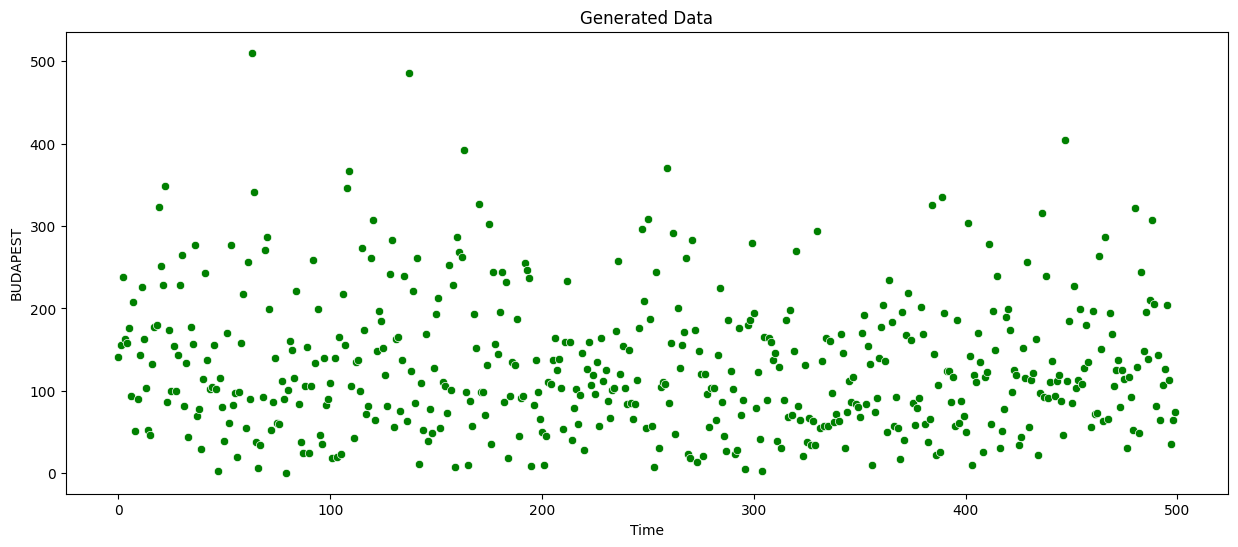

In [22]:

# Plot the generated data
fig, axes = plt.subplots(figsize=(15, 6))
sns.scatterplot(data=df_gen,x=df_gen.index, y=df_gen[names[0]], color='g')
axes.set_title('Generated Data')
axes.set_xlabel("Time")

Text(0.5, 0, 'Time')

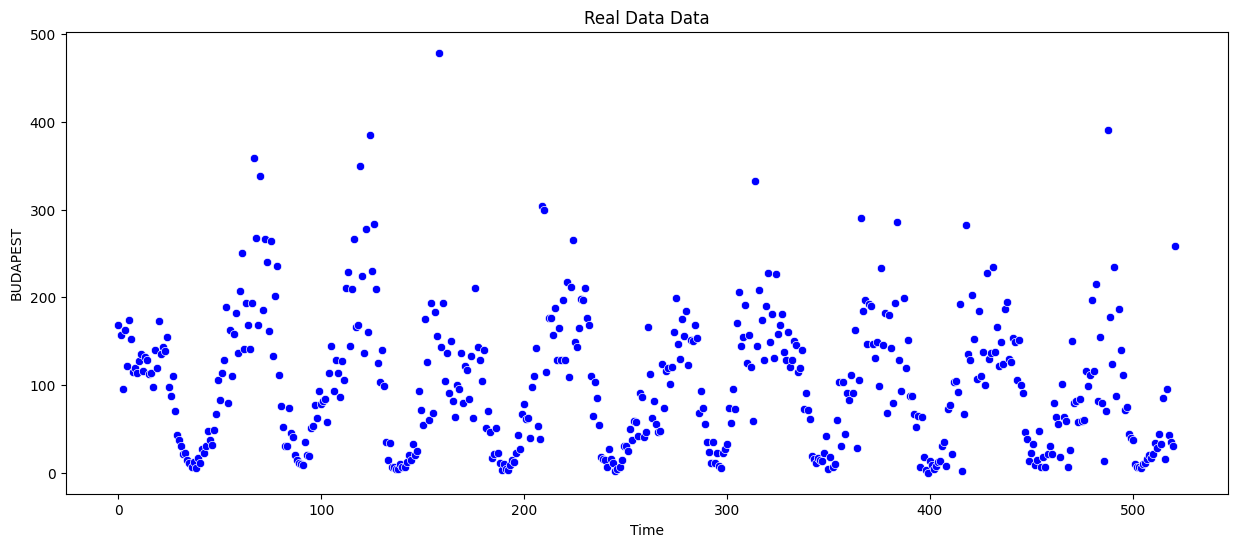

In [23]:
# This is what the real data time series looks like

fig, axes = plt.subplots(figsize=(15, 6))
sns.scatterplot(data=df,x=df.index, y=df[names[0]], color='b')
axes.set_title('Real Data Data')
axes.set_xlabel("Time")

In [18]:
# sns.pairplot(df_gen)

Text(0.5, 1.0, 'Real vs Generated Data')

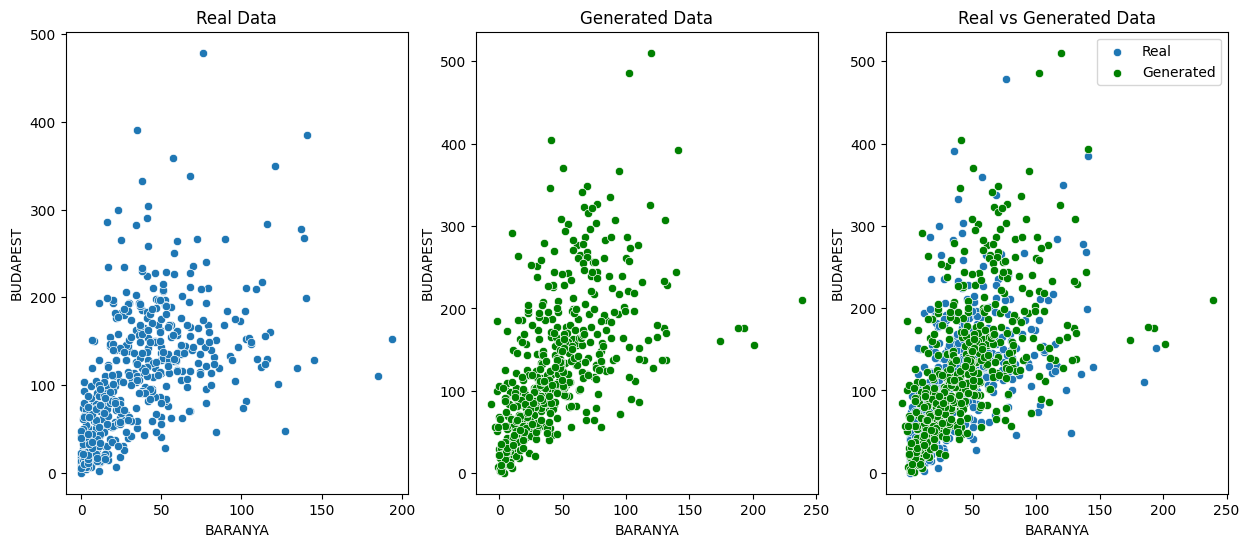

In [19]:
# Plotting Real vs Generated data
fig, axes = plt.subplots(1, 3, figsize=(15, 6))


sns.scatterplot(ax=axes[0],x=names[1], y=names[0], data=df)
axes[0].set_title('Real Data')

sns.scatterplot(ax=axes[1], data=df_gen,x=names[1], y=df_gen[names[0]], color='g')
axes[1].set_title('Generated Data')

sns.scatterplot(ax=axes[2], data=df, x=names[1], y=names[0], label='Real')
sns.scatterplot(ax=axes[2], data=df_gen, x=names[1], y=names[0], color='g', label= 'Generated')
axes[2].set_title('Real vs Generated Data')


In [20]:
# n = len(tensor_pieces)
# for i in range(n):
#     train_loader = torch.utils.data.DataLoader(tensor_pieces[0], batch_size=batch_size)
#     training_loop(num_epochs, train_loader, lr)
    
#     latent_space_samples = torch.randn((batch_size), df_dim)
#     generated_samples = generator(latent_space_samples)
#     generated_samples = generated_samples.detach()
#     df_gen=pd.DataFrame(generated_samples)
#     df_gen = df_gen.set_axis(names, axis=1, inplace=False)
#     sns.scatterplot(data=df_gen,x=names[1], y=df_gen[names[0]], color='g')

# sns.scatterplot(x=names[1], y=names[0], data=df)

In [21]:
print('Current Model Parameters:')
print('Size of dataset:', num_data)
print('Number of epochs:', num_epochs)
print('Learning Rate:', lr)
print('Discriminator dropout:', drop_out)
print('Batch Size:', batch_size)

Current Model Parameters:
Size of dataset: 500
Number of epochs: 1000
Learning Rate: 0.003
Discriminator dropout: 0.2
Batch Size: 25
